In [29]:
from datetime import datetime as dt

import pandas as pd
import numpy as np

from preprocessing import Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.utils import resample



from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, RocCurveDisplay

# Preprocessing

In [4]:
col_drop = ['CustomerId','Surname']
types = {
    'HasCrCard':bool,
    'IsActiveMember':bool
}
train = pd.read_csv('data/train.csv', index_col='id', dtype=types).drop(columns=col_drop)
test = pd.read_csv('data/test.csv', index_col='id', dtype=types).drop(columns=col_drop)

In [5]:
train.shape

(165034, 11)

In [6]:
X = train.drop(columns='Exited')
y = train.Exited

In [12]:
X_train,X_test,y_train,y_test = train_test_split(X,y, stratify=y, test_size=0.15)

In [13]:
prepro_train = Preprocessing()

In [14]:
X_train_scld = prepro_train.fit_transform(X_train).astype(float)
X_test_scld = prepro_train.transform(X_test).astype(float)

In [15]:
prepro_X = Preprocessing()

In [16]:
X_scld = prepro_X.fit_transform(X).astype(float)

In [30]:
X_train_balanced, y_train_balanced = resample(X_train_scld[y_train == 1], y_train[y_train == 1], n_samples=np.sum(y_train == 0), replace=True, random_state=42)

In [31]:
X_train_balanced = np.concatenate((X_train_scld[y_train == 0], X_train_balanced))
y_train_balanced = np.concatenate((y_train[y_train == 0], y_train_balanced))

# Model

In [30]:
results = {
    'models' : [
        ('rf', RandomForestClassifier()),
        ('histgradboost', HistGradientBoostingClassifier()),
        ('gradboost', GradientBoostingClassifier()),
        ('adaboost', AdaBoostClassifier()),
        ('Xgb', XGBClassifier()),
        ('Catboost',CatBoostClassifier(verbose=False))
        ],
    'mean_score' :[],
    'std_dev_score' :[] 
}
for _, model in results.get('models') :
    scores = cross_val_score(model,
                            X_scld,
                            y,
                            scoring = 'roc_auc',
                            cv = 4,
                            n_jobs = -1)
    results['mean_score'].append(scores.mean())
    results['std_dev_score'].append(scores.std())
    
    name = type(model).__name__ 
    print(f'{name} - Roc AUC score: {scores.mean():.4f} ± {scores.std():.4f}')

RandomForestClassifier - Roc AUC score: 0.8736 ± 0.0022
HistGradientBoostingClassifier - Roc AUC score: 0.8891 ± 0.0012
GradientBoostingClassifier - Roc AUC score: 0.8882 ± 0.0010
AdaBoostClassifier - Roc AUC score: 0.8801 ± 0.0012
XGBClassifier - Roc AUC score: 0.8864 ± 0.0013
Learning rate set to 0.080629
Learning rate set to 0.080628
Learning rate set to 0.080629
Learning rate set to 0.080628
0:	learn: 0.6182588	total: 70.9ms	remaining: 1m 10s
0:	learn: 0.6179272	total: 71ms	remaining: 1m 10s
0:	learn: 0.6178774	total: 71ms	remaining: 1m 10s
0:	learn: 0.6179033	total: 72.1ms	remaining: 1m 12s
1:	learn: 0.5593643	total: 83.7ms	remaining: 41.7s
1:	learn: 0.5591460	total: 85ms	remaining: 42.4s
1:	learn: 0.5591765	total: 85.8ms	remaining: 42.8s
1:	learn: 0.5590788	total: 85.9ms	remaining: 42.9s
2:	learn: 0.5152281	total: 95.9ms	remaining: 31.9s
2:	learn: 0.5143641	total: 98.7ms	remaining: 32.8s
2:	learn: 0.5144566	total: 100ms	remaining: 33.4s
2:	learn: 0.5142862	total: 99.5ms	remaining

In [31]:
voting = VotingClassifier(
    estimators=results.get('models'),
    voting='soft',
    weights=results.get('mean_score')
)

In [32]:
voting.fit(X_scld,y)

Learning rate set to 0.091167
0:	learn: 0.6090707	total: 66.2ms	remaining: 1m 6s
1:	learn: 0.5454483	total: 73.5ms	remaining: 36.7s
2:	learn: 0.4987385	total: 80.9ms	remaining: 26.9s
3:	learn: 0.4619732	total: 89ms	remaining: 22.2s
4:	learn: 0.4349372	total: 96.2ms	remaining: 19.1s
5:	learn: 0.4124694	total: 104ms	remaining: 17.2s
6:	learn: 0.3961318	total: 112ms	remaining: 15.9s
7:	learn: 0.3831449	total: 120ms	remaining: 14.9s
8:	learn: 0.3718302	total: 128ms	remaining: 14.1s
9:	learn: 0.3636582	total: 135ms	remaining: 13.4s
10:	learn: 0.3569111	total: 143ms	remaining: 12.8s
11:	learn: 0.3512055	total: 150ms	remaining: 12.4s
12:	learn: 0.3468613	total: 158ms	remaining: 12s
13:	learn: 0.3428594	total: 166ms	remaining: 11.7s
14:	learn: 0.3401819	total: 172ms	remaining: 11.3s
15:	learn: 0.3378982	total: 180ms	remaining: 11s
16:	learn: 0.3356812	total: 187ms	remaining: 10.8s
17:	learn: 0.3339769	total: 194ms	remaining: 10.6s
18:	learn: 0.3327743	total: 209ms	remaining: 10.8s
19:	learn: 0

VotingClassifier(estimators=[('rf', RandomForestClassifier()),
                             ('histgradboost',
                              HistGradientBoostingClassifier()),
                             ('gradboost', GradientBoostingClassifier()),
                             ('adaboost', AdaBoostClassifier()),
                             ('Xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_ro...
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('Catboost',
                              <catboost.core.CatBoostClassifier object at 0x2b7a1c210>)],
                 voting='soft',
                 weights=[0.8735700872459329, 0.8890955442021964,
                          0.8882242837631675, 0.8801223208688662,
                          0.8863980557186306, 0.8885333128867414])

In [35]:
pred = voting.predict(X_test_scld)
pred_proba = voting.predict_proba(X_test_scld)[:,1]

# Score

In [36]:
RocScore  = roc_auc_score(y_test, pred_proba)
print(f'Roc Auc Score : {RocScore:.6f}')

Roc Auc Score : 0.889617


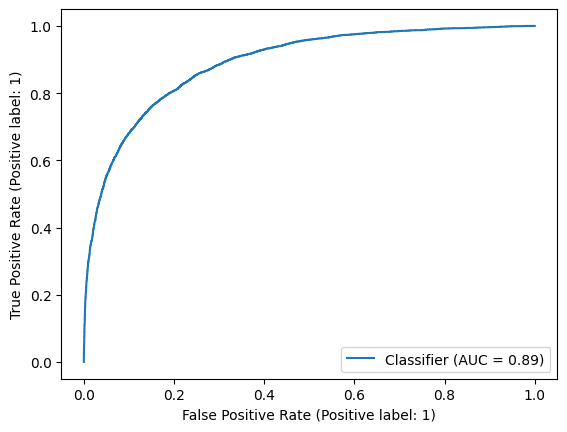

In [37]:
RocCurveDisplay.from_predictions(y_test,pred_proba)

# Submission

In [33]:
X_val_scld = prepro_X.transform(test).astype(float)

In [34]:
submission = pd.read_csv("data/sample_submission.csv", index_col='id')

In [35]:
submission.loc[:,'Exited'] = voting.predict_proba(X_val_scld.values)[:,1]

/Users/marc/Library/Mobile Documents/com~apple~CloudDocs/Projects/Playground/playgroundseries_s4e1/.venv/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/marc/Library/Mobile Documents/com~apple~CloudDocs/Projects/Playground/playgroundseries_s4e1/.venv/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but HistGradientBoostingClassifier was fitted with feature names
  warnings.warn(
/Users/marc/Library/Mobile Documents/com~apple~CloudDocs/Projects/Playground/playgroundseries_s4e1/.venv/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/Users/marc/Library/Mobile Documents/com~apple~CloudDocs/Projects/Playground/playgroundseries_s4e1/.venv/lib/python3.11/site-packages/sklearn/base.py:4

In [36]:
submission

,Exited
id,
165034,0.095765
165035,0.794204
165036,0.098894
165037,0.267940
165038,0.372429
...,...
275052,0.121283
275053,0.163445
275054,0.093715


In [26]:
name = dt.now().strftime("%Y%m%d_%H%M")

In [27]:
submission.to_csv(f"submission/{name}.csv")